## Install + Import

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_recall_fscore_support

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load processed data

In [2]:
train_df = pd.read_csv("../data/processed/train.csv")
val_df   = pd.read_csv("../data/processed/val.csv")
test_df  = pd.read_csv("../data/processed/test.csv")

train_df["text"] = train_df["text"].astype(str)
val_df["text"]   = val_df["text"].astype(str)
test_df["text"]  = test_df["text"].astype(str)

print(train_df.shape, val_df.shape, test_df.shape)
train_df.head()

(35918, 2) (4490, 2) (4490, 2)


,text,label
0,trump asks supreme court to block travel ban r...,0
1,insight emails show how republicans lobbied to...,0
2,jailed british iranian charity worker received...,0
3,trump gets torn to shreds after his fake news ...,1
4,trump offers support for bathroom access based...,0


## Convert to HuggingFace Dataset

In [3]:
train_ds = Dataset.from_pandas(train_df)
val_ds   = Dataset.from_pandas(val_df)
test_ds  = Dataset.from_pandas(test_df)

## Tokenizer + Tokenization (DistilBERT)

In [4]:
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

MAX_LEN = 256

def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True, max_length=MAX_LEN)

train_tok = train_ds.map(tokenize_fn, batched=True)
val_tok   = val_ds.map(tokenize_fn, batched=True)
test_tok  = test_ds.map(tokenize_fn, batched=True)

train_tok = train_tok.rename_column("label", "labels")
val_tok   = val_tok.rename_column("label", "labels")
test_tok  = test_tok.rename_column("label", "labels")

cols_to_remove = [c for c in train_tok.column_names if c not in ["input_ids", "attention_mask", "labels"]]
train_tok = train_tok.remove_columns(cols_to_remove)
val_tok   = val_tok.remove_columns(cols_to_remove)
test_tok  = test_tok.remove_columns(cols_to_remove)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ASUS\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Map: 100%|██████████| 4490/4490 [00:01<00:00, 3467.52 examples/s]


## Load model

In [5]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print("Device:", device)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Device: cuda


## Metrics

In [6]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", zero_division=0)

    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

## TrainingArguments + Trainer

In [7]:
os.makedirs("../models/distilbert", exist_ok=True)

training_args = TrainingArguments(
    output_dir="../models/distilbert/checkpoints",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,

    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,

    logging_dir="../models/distilbert/logs",
    logging_steps=50,

    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

## Train

In [8]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000300,0.005100,0.999109,0.998723,0.999574,0.999149
2,0.000100,0.005844,0.999109,0.999148,0.999148,0.999148


TrainOutput(global_step=4490, training_loss=0.00925751446605243, metrics={'train_runtime': 1921.2733, 'train_samples_per_second': 37.39, 'train_steps_per_second': 2.337, 'total_flos': 4757964024926208.0, 'train_loss': 0.00925751446605243, 'epoch': 2.0})

## Plot Loss

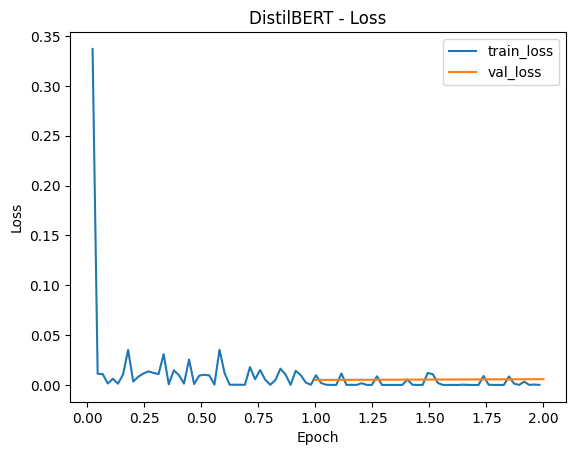

In [9]:
logs = trainer.state.log_history
train_losses = [x["loss"] for x in logs if "loss" in x and "epoch" in x]
train_epochs = [x["epoch"] for x in logs if "loss" in x and "epoch" in x]

eval_losses = [x["eval_loss"] for x in logs if "eval_loss" in x and "epoch" in x]
eval_epochs = [x["epoch"] for x in logs if "eval_loss" in x and "epoch" in x]

plt.figure()
if len(train_losses) > 0:
    plt.plot(train_epochs, train_losses, label="train_loss")
if len(eval_losses) > 0:
    plt.plot(eval_epochs, eval_losses, label="val_loss")
plt.title("DistilBERT - Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Evaluate on Test (Report + Confusion Matrix)

Classification Report (DistilBERT):
              precision    recall  f1-score   support

        Real       1.00      1.00      1.00      2142
        Fake       1.00      1.00      1.00      2348

    accuracy                           1.00      4490
   macro avg       1.00      1.00      1.00      4490
weighted avg       1.00      1.00      1.00      4490



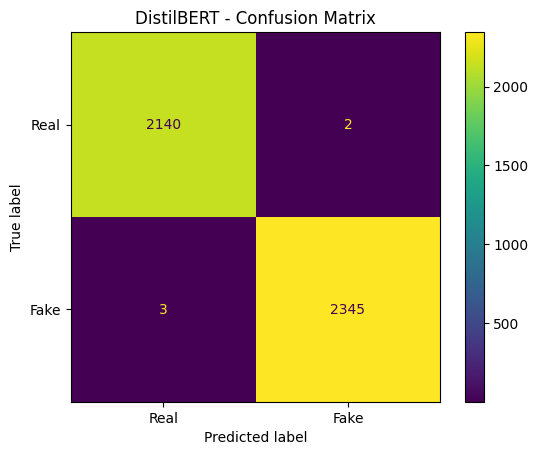

In [10]:
pred = trainer.predict(test_tok)
logits = pred.predictions
y_true = pred.label_ids
y_pred = np.argmax(logits, axis=-1)

print("Classification Report (DistilBERT):")
print(classification_report(y_true, y_pred, target_names=["Real", "Fake"]))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])
disp.plot()
plt.title("DistilBERT - Confusion Matrix")
plt.show()

## Save final model + tokenizer (untuk Streamlit)

In [11]:
save_dir = "../models/distilbert/final"
os.makedirs(save_dir, exist_ok=True)

trainer.model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

print("Saved DistilBERT model & tokenizer to:", save_dir)

Saved DistilBERT model & tokenizer to: ../models/distilbert/final
